## Setup

In [1]:
import time
import random 
import pennylane as qml
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import pandas as pd
import math
import os
import csv
import sys

print("+"*50)
print("Breast Cancer Detection")
print("+"*50)
print("\n")


print(f"PennyLane version = {qml.version()}")
print(f"Pytorch version = {torch. __version__ }")

setgrad = lambda g, *ms: [setattr(p,'requires_grad', g) for m in ms for p in m.parameters() ]

SYS_SEED = 0
SYS_BATCH_SIZE =  16
SYS_LEARNING_RATE = 0.5
SYS_LAYERS = 2

EPOCHS_SETTING = 50

# REPRODUCIBILITY 
SEED = SYS_SEED   # Seed for random initial weights
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# AE
LEARNING_RATE_AE = 0.01
BATCH_SIZE_AE = 32
EPOCHS_AE = 500
ENCODER_ACTIVATION_FN = nn.Sigmoid()
DECODER_ACTIVATION_FN = nn.Sigmoid()

# VQC with Angle Embedding
LEARNING_RATE_VQC = SYS_LEARNING_RATE
BATCH_SIZE_VQC =  SYS_BATCH_SIZE
EPOCHS_VQC = EPOCHS_SETTING
LAYERS_ANGLE_EMBEDDING = SYS_LAYERS

# VQC with Amplitude Embedding
LEARNING_RATE_VQC_AMPLITUDE_EMBEDDING = SYS_LEARNING_RATE
BATCH_SIZE_VQC_AMPLITUDE_EMBEDDING =  SYS_BATCH_SIZE
EPOCHS_VQC_AMPLITUDE_EMBEDDING = EPOCHS_SETTING
LAYERS_AMPLITUDE_EMBEDDING = SYS_LAYERS

# NN on original Input
LEARNING_RATE_ONLY_NN = SYS_LEARNING_RATE
BATCH_SIZE_ONLY_NN = SYS_BATCH_SIZE
EPOCHS_ONLY_NN = EPOCHS_SETTING

# NN on compressed Input (with AE before) 
LEARNING_RATE_AE_NN = SYS_LEARNING_RATE
BATCH_SIZE_AE_NN = SYS_BATCH_SIZE
EPOCHS_AE_NN = EPOCHS_SETTING

# SEQUENT
PREPROCESSING_SEQUENT_ACTICATION_FN = nn.Sigmoid()
LEARNING_RATE_SEQUENT = SYS_LEARNING_RATE
BATCH_SIZE_SEQUENT = SYS_BATCH_SIZE
EPOCHS_SEQUENT = EPOCHS_SETTING
LAYERS_SEQUENT = SYS_LAYERS

# DRESSED
PREPROCESSING_DRESSED_ACTICATION_FN = nn.Sigmoid()
LEARNING_RATE_DRESSED =  SYS_LEARNING_RATE
BATCH_SIZE_DRESSED = SYS_BATCH_SIZE
EPOCHS_DRESSED = EPOCHS_SETTING
LAYERS_DRESSED = SYS_LAYERS


print('-' * 50)
print('-' * 50)
print('-' * 50)

# Print the information
print("Reproducibility:")
print(f"Seed: {SEED}")
print("\nAE:")
print(f"- Learning Rate: {LEARNING_RATE_AE}")
print(f"- Batch Size: {BATCH_SIZE_AE}")
print(f"- Epochs: {EPOCHS_AE}")
print(f"- Encoder Activation Function: {ENCODER_ACTIVATION_FN}")
print(f"- Decoder Activation Function: {DECODER_ACTIVATION_FN}")
print("\nVQC with Angle Embedding:")
print(f"- Learning Rate: {LEARNING_RATE_VQC}")
print(f"- Batch Size: {BATCH_SIZE_VQC}")
print(f"- Epochs: {EPOCHS_VQC}")
print(f"- Layers: {LAYERS_ANGLE_EMBEDDING}")
print("\nVQC with Amplitude Embedding:")
print(f"- Learning Rate: {LEARNING_RATE_VQC_AMPLITUDE_EMBEDDING}")
print(f"- Batch Size: {BATCH_SIZE_VQC_AMPLITUDE_EMBEDDING}")
print(f"- Epochs: {EPOCHS_VQC_AMPLITUDE_EMBEDDING}")
print(f"- Layers: {LAYERS_AMPLITUDE_EMBEDDING}")
print("\nNN on Original Input:")
print(f"- Learning Rate: {LEARNING_RATE_ONLY_NN}")
print(f"- Batch Size: {BATCH_SIZE_ONLY_NN}")
print(f"- Epochs: {EPOCHS_ONLY_NN}")
print("\nNN on Compressed Input (with AE before):")
print(f"- Learning Rate: {LEARNING_RATE_AE_NN}")
print(f"- Batch Size: {BATCH_SIZE_AE_NN}")
print(f"- Epochs: {EPOCHS_AE_NN}")
print("\nSequent:")
print(f"- Preprocessing Activation Function: {PREPROCESSING_SEQUENT_ACTICATION_FN}")
print(f"- Learning Rate: {LEARNING_RATE_SEQUENT}")
print(f"- Batch Size: {BATCH_SIZE_SEQUENT}")
print(f"- Epochs: {EPOCHS_SEQUENT}")
print(f"- Layers: {LAYERS_SEQUENT}")
print("\nDressed Quantum Circuit:")
print(f"- Preprocessing Activation Function: {PREPROCESSING_DRESSED_ACTICATION_FN}")
print(f"- Learning Rate: {LEARNING_RATE_DRESSED}")
print(f"- Batch Size: {BATCH_SIZE_DRESSED}")
print(f"- Epochs: {EPOCHS_DRESSED}")
print(f"- Layers: {LAYERS_DRESSED}")


print('-' * 50)
print('-' * 50)
print('-' * 50)

++++++++++++++++++++++++++++++++++++++++++++++++++
Breast Cancer Detection
++++++++++++++++++++++++++++++++++++++++++++++++++


PennyLane version = 0.27.0
Pytorch version = 1.9.0+cpu
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
Reproducibility:
Seed: 0

AE:
- Learning Rate: 0.0001
- Batch Size: 32
- Epochs: 500
- Encoder Activation Function: Sigmoid()
- Decoder Activation Function: Sigmoid()

VQC with Angle Embedding:
- Learning Rate: 0.5
- Batch Size: 16
- Epochs: 50
- Layers: 2

VQC with Amplitude Embedding:
- Learning Rate: 0.5
- Batch Size: 16
- Epochs: 50
- Layers: 2

NN on Original Input:
- Learning Rate: 0.5
- Batch Size: 16
- Epochs: 50

NN on Compressed Input (with AE before):
- Learning Rate: 0.5
- Batch Size: 16
- Epochs: 50

Sequent:
- Preprocessing Activation Function: Sigmoid()
- Learning Rate: 0.5
- Batch Size: 16
- Epochs: 50
- Layers: 2

Dressed Quantum Circuit:


## Getting data ready

In [2]:
class BreastCancerDataset(Dataset):
    def __init__(self, train=False, validation=False, test=False, seed=SEED):
        # load data (no missing values present)
        breast_cancer = load_breast_cancer()

        # Split the dataset into X and y
        X = breast_cancer.data
        y = breast_cancer.target

        # Store the input dimension of X
        self.input_dimension = len(breast_cancer.feature_names)
        # Store the output dimension
        self.num_classes = len(breast_cancer.target_names)

        # Store the feature names
        self.feature_names = breast_cancer.feature_names
        # Store the label name
        self.label_names = breast_cancer.target_names

        # Convert y to integer labels (already present)

        # Apply one-hot encoding to y 
        y = np.eye(self.num_classes)[y]

        # Apply Scaling
        # X = StandardScaler().fit_transform(X)
        scaler = MinMaxScaler(feature_range=(0, 1))
        X = scaler.fit_transform(X)

        # Split: 80%, 10%, 10%
        # here it makes no difference if we split the train-set into training & validation or the test-set because it comes from the same dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed, shuffle=True)

        if train:
            self.X = torch.tensor(X_train, dtype=torch.float32)
            self.y = torch.tensor(y_train, dtype=torch.float32)
        elif validation:
            self.X = torch.tensor(X_val, dtype=torch.float32)
            self.y = torch.tensor(y_val, dtype=torch.float32)     
        elif test:
            self.X = torch.tensor(X_test, dtype=torch.float32)
            self.y = torch.tensor(y_test, dtype=torch.float32) 
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return X, y 

    def visualize_output_distribution(self):
        # Count the occurrences of each class
        class_counts = self.y.sum(dim=0)

        # Get the class labels
        class_labels = self.label_names

        # Plot the output distribution
        plt.bar(class_labels, class_counts)
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Output Distribution')
        plt.show()

In [3]:
breast_cancer_train = BreastCancerDataset(train=True)
breast_cancer_validation = BreastCancerDataset(validation=True)
breast_cancer_test = BreastCancerDataset(test=True)


num_classes = breast_cancer_train.num_classes
input_dimension = breast_cancer_train.input_dimension

# angle embedding: Encodes N features into the rotation angles of n qubits, where N≤n
VQC_width = num_classes
# amplitude embedding: Encodes 2^n features into the amplitude vector of n qubits.
wires_amplitude = max(math.ceil(math.log(input_dimension, 2)), num_classes) #at least as many qubits as output classes

In [4]:
len(breast_cancer_train), len(breast_cancer_validation), len(breast_cancer_test)

(455, 57, 57)

In [5]:
X_train_max = torch.max(breast_cancer_train.X)
X_train_min = torch.min(breast_cancer_train.X)
X_test_max = torch.max(breast_cancer_test.X)
X_test_min = torch.min(breast_cancer_test.X)


print(f"Maximum of X_train: {X_train_max}")
print(f"Minimum of X_train: {X_train_min}")
print(f"Maximum of X_test: {X_test_max}")
print(f"Minimum of X_test: {X_test_min}")

Maximum of X_train: 1.0
Minimum of X_train: 0.0
Maximum of X_test: 1.0
Minimum of X_test: 0.0


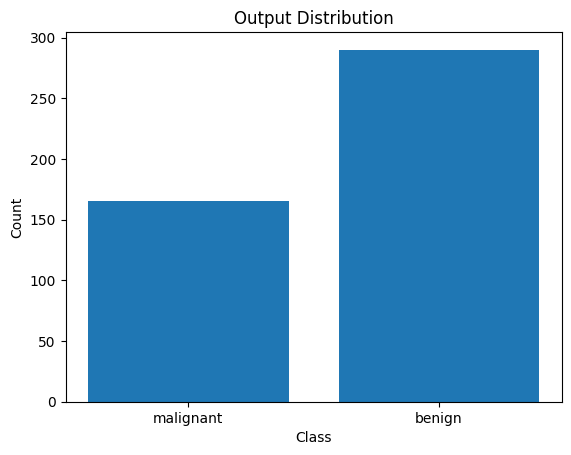

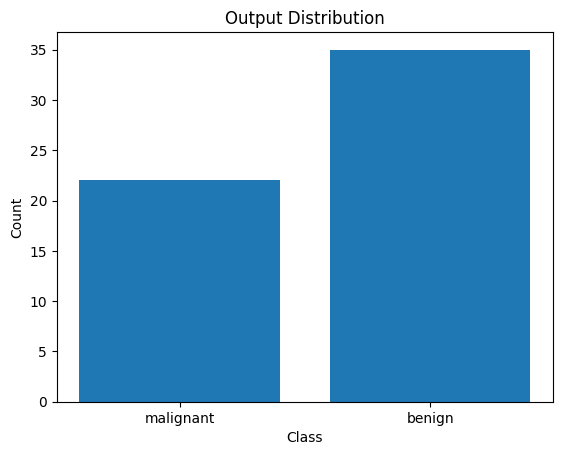

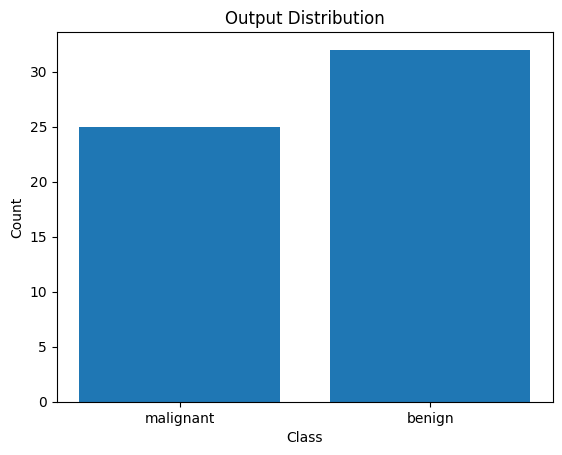

In [6]:
breast_cancer_train.visualize_output_distribution()
breast_cancer_validation.visualize_output_distribution()
breast_cancer_test.visualize_output_distribution()

## Models

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, encoder_last_layer_activation=ENCODER_ACTIVATION_FN, decoder_last_layer_activation=DECODER_ACTIVATION_FN):
        super().__init__()

        # calculate the number of neurons for each layer
        neuron_list = []
        running_size = input_size
        while(running_size > hidden_size):
            neuron_list.append(running_size)
            running_size = running_size // 2
        neuron_list.append(hidden_size)

        # Encoder layers
        encoder_layers = []
        length = len(neuron_list)
        for i in range(length-1):
            encoder_layers.append(nn.Linear(neuron_list[i], neuron_list[i+1]))
            if(i != length-2):
                encoder_layers.append(nn.ReLU())
            else:
                encoder_layers.append(encoder_last_layer_activation)
        print(encoder_layers)
        self.encoder = nn.Sequential(*encoder_layers) # asterisk (*) operator to unpack the list into separate arguments


        # Decoder layers
        decoder_layers = []
        for i in range(length - 1, 0, -1):
            decoder_layers.append(nn.Linear(neuron_list[i], neuron_list[i-1]))
            if(i != 1):
                decoder_layers.append(nn.ReLU())
            else:
                decoder_layers.append(decoder_last_layer_activation)

        print(decoder_layers)

        self.decoder = nn.Sequential(*decoder_layers)


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
# Sigmoid activation function to get values between 0 and 1

In [8]:
"""Layer of single-qubit Hadamard gates. """
def Hadamard(nqubits):
    return [qml.Hadamard(wires=idx) for idx in range(nqubits)]
        
"""Layer of parametrized qubit rotations around the y axis."""
def Rotation(w):
    return [qml.RY(element, wires=idx) for idx, element in enumerate(w)]

"""Layer of shifted CNots."""
def CNot(start, nqubits):
    return [qml.CNOT(wires=[i, i + 1]) for i in range(start, nqubits - 1, 2)] 

"""Layer of CNOTs followed by another shifted layer of CNOTs and a Rotation Layer"""   
def Entangle(weights): 
    return [[*CNot(0, len(w)), *CNot(1, len(w)), *Rotation(w)] for w in weights]

"""Expectation values in the Z basis."""
def Measure(wires):
    return [qml.expval(qml.PauliZ(position)) for position in wires]  



dev_angle_embedding = qml.device('lightning.qubit', wires=VQC_width)
dev_amplitude_embedding = qml.device('lightning.qubit', wires=wires_amplitude)


@qml.qnode(dev_angle_embedding, interface="torch", diff_method='adjoint')
def variational_circuit_angle_embedding(input, weights, out):
    weights =  2.0 * torch.arctan(2 * weights) # weight remapping
    width = weights.shape[1]    
    assert input.shape[0] == width, f"Expected input of len {width}"
    input = input * np.pi - np.pi / 2.0   # Rescale [0, 1] to [-pi/2, pi/2]
    Hadamard(width)               # Start from state |+> , unbiased w.r.t. |0> and |1>
    Rotation(input)               # Embed features in the quantum node 
    Entangle(weights)             # Sequence of trainable variational layers
    return Measure(range(out))    # Expectation values in the Z basis



@qml.qnode(dev_amplitude_embedding, interface="torch", diff_method='adjoint')
def variational_circuit_amplitude_embedding(input, weights, out):
    torch_pi = torch.tensor(math.pi)
    weights =  torch_pi * torch.tanh(weights) # weight remapping
    width = weights.shape[1]    
    input = input.tolist()
    qml.AmplitudeEmbedding(features=input, wires=range(width), normalize=True, pad_with=0.)  # Embed features in the quantum node
    Entangle(weights)             # Sequence of trainable variational layers
    return Measure(range(out))    # Expectation values in the Z basis



class Circuit(nn.Module):
    def __init__(self, width, depth, out, amplitude_embedding):
        super().__init__()
        self.out = out
        self.params = torch.nn.Parameter(torch.randn(depth, width))
        self.amplitude_embedding = amplitude_embedding

    def forward(self, input):
        if len(input.shape) > 1: return torch.cat([self(i).float().unsqueeze(0) for i in input])
        if self.amplitude_embedding:
            return variational_circuit_amplitude_embedding(input, self.params, self.out).float()
        else:
            return variational_circuit_angle_embedding(input, self.params, self.out).float()

In [9]:
"""
input,params = torch.randn(VQC_width), torch.nn.Parameter(torch.randn(LAYERS_ANGLE_EMBEDDING, VQC_width))
print("Circuit with Angle Embedding")
print(qml.draw(variational_circuit_angle_embedding)(input, params, num_classes))
print("\nCircuit with Amplitude Embedding")
input,params = torch.randn(input_dimension), torch.nn.Parameter(torch.randn(LAYERS_AMPLITUDE_EMBEDDING, wires_amplitude))
print(qml.draw(variational_circuit_amplitude_embedding)(input, params, num_classes))
"""

'\ninput,params = torch.randn(VQC_width), torch.nn.Parameter(torch.randn(LAYERS_ANGLE_EMBEDDING, VQC_width))\nprint("Circuit with Angle Embedding")\nprint(qml.draw(variational_circuit_angle_embedding)(input, params, num_classes))\nprint("\nCircuit with Amplitude Embedding")\ninput,params = torch.randn(input_dimension), torch.nn.Parameter(torch.randn(LAYERS_AMPLITUDE_EMBEDDING, wires_amplitude))\nprint(qml.draw(variational_circuit_amplitude_embedding)(input, params, num_classes))\n'

In [10]:
class ClassicalNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [11]:
class DressedQuantumCircuit(torch.nn.Module):
  def __init__(self, width, depth, i=input_dimension, o=num_classes):
    """ :param i,o: Input, Output dimension, :params width, depth: Internal net width (i.e. n_qubits) and depth (number of variational layers)"""
    super().__init__()
    self.pre_processing  = torch.nn.Sequential(torch.nn.Linear(i, width), PREPROCESSING_DRESSED_ACTICATION_FN) 
    self.circuit = Circuit(width, depth, width, amplitude_embedding=False)
    self.post_processing = torch.nn.Linear(width, o)
  
  def train(self, mode): 
    if mode == 'classical': setgrad(True, self.pre_processing, self.post_processing); setgrad(False, self.circuit)
    if mode == 'quantum': setgrad(True, self.circuit); setgrad(False, self.pre_processing, self.post_processing)
    if mode == 'hybrid': setgrad(True, self.pre_processing, self.circuit, self.post_processing)

  def forward(self, input): return self.post_processing(self.circuit(self.pre_processing(input.float())))

In [12]:
class SEQUENT(torch.nn.Module):
  """ Sequential Quantum Enhanced Training (SEQUENT) """
  def __init__(self, width, depth, i=input_dimension, o=num_classes):
    """ :params i,o: Input, Output dimension, :params width, depth: Internal net width (i.e. n_qubits) and depth (number of variational layers)"""
    super().__init__()
    self.compression  = torch.nn.Sequential(torch.nn.Linear(i, width),PREPROCESSING_SEQUENT_ACTICATION_FN) 
    self.surrogate = torch.nn.Sequential(torch.nn.Linear(width, o))
    self.circuit = Circuit(width, depth, o, amplitude_embedding=False)

  def train(self, mode): 
    if mode == 'classical': self.classification = self.surrogate; setgrad(False, self.circuit); setgrad(True, self.compression, self.surrogate)
    if mode == 'quantum': self.classification = self.circuit; setgrad(True, self.circuit); setgrad(False, self.compression, self.surrogate)
    if mode == 'hybrid': self.classification = self.circuit; setgrad(True, self.compression, self.circuit); setgrad(False, self.surrogate)

  def forward(self, input): return self.classification(self.compression(input.float()))

## Testing Functions

In [13]:
def test_autoencoder(model, dataset_test, batch_size):
    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    test_loss = 0.0

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        for original_images_val, _ in dataloader_test:
            recon_images_val = model(original_images_val)
            loss = criterion(recon_images_val, original_images_val)
            test_loss += loss.item() * original_images_val.shape[0] 

    # Compute average test loss for the epoch
    test_loss /= len(dataloader_test.dataset)

    return test_loss

In [20]:
def test_model(model, dataset_test, batch_size):
    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
    model.eval()
    results_list = []
    test_loss = 0.0
    total_accuracy = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch_inputs, batch_labels in dataloader_test:
            test_predictions = model(batch_inputs)
            y_probs = torch.softmax(test_predictions, dim=1)
            y_preds = torch.argmax(y_probs, dim=1)
            y_trues = torch.argmax(batch_labels, dim=1)
            
            for i in range(len(batch_inputs)):
                sample_result = (y_trues[i].item(), y_preds[i].item(), y_probs[i].tolist())
                results_list.append(sample_result)

            # Compute the test loss
            loss = criterion(test_predictions, y_trues)
            test_loss += loss.item() * batch_inputs.shape[0]

            # Compute the test accuracy
            total_accuracy += (y_preds == y_trues).sum().item()

    # Calculate average test loss and test accuracy
    avg_test_loss = test_loss / len(dataset_test)
    avg_test_accuracy = total_accuracy / len(dataset_test)


    return results_list, avg_test_loss, avg_test_accuracy

## Training Functions

In [15]:
def train_and_validate_autoencoder(model, dataset_train, dataset_validation, batch_size, num_epochs, learning_rate):
    # Define the dataloader for efficient batch training
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_validation = torch.utils.data.DataLoader(dataset_validation, batch_size=batch_size, shuffle=True)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_values = []

    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        start_time = time.time()

        # Train the model
        model.train()
        for original_images, _ in dataloader_train:
            optimizer.zero_grad()
            recon_image = model(original_images)
            loss = criterion(recon_image, original_images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * original_images.size(0) # loss.item() * batch_size

        # Compute average training loss for the epoch
        train_loss /= len(dataloader_train.dataset)

        # Evaluate the model on the validation set
        model.eval()
        with torch.no_grad():
            for original_images_val, _ in dataloader_validation:
                recon_images_val = model(original_images_val)
                loss = criterion(recon_images_val, original_images_val)
                val_loss += loss.item() * original_images_val.size(0) 

        # Compute average validation loss for the epoch
        val_loss /= len(dataloader_validation.dataset)

        end_time = time.time()
        epoch_time = end_time - start_time

        loss_values.append((epoch+1, train_loss, val_loss, epoch_time))
        
        # print out
        print(f"Epoch: [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Epoch Time: {epoch_time:.2f} seconds")

    return loss_values

In [16]:
def show_parameters(model):
    for p in model.parameters():
        print(p)
        print(f"p.shape: {p.shape}")

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) 
    #numel() in order to calculate the total number of elements in a PyTorch tensor or parameter.


def train_and_validate_model(model, dataset_train, dataset_validation, batch_size, num_epochs, learning_rate):    
    # Define the dataloader for efficient batch training
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_validation = torch.utils.data.DataLoader(dataset_validation, batch_size=batch_size, shuffle=True)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    result_list = []

    for epoch in range(num_epochs):
        # Initialize the total loss and accuracy for this epoch
        total_loss = 0.0
        total_accuracy = 0.0

        start_time = time.time()

        # Train the model
        model.train()

        # Loop over the batches
        for batch_inputs, batch_labels in dataloader_train:
            # Reset the gradients
            optimizer.zero_grad()
            # Compute the predictions
            train_predictions = model(batch_inputs)
            # Compute the loss
            loss = criterion(train_predictions, batch_labels.argmax(dim=1))
            # Accumulate the loss and accuracy
            total_loss += loss.item() * batch_inputs.shape[0]
            total_accuracy += (train_predictions.argmax(axis=1) == batch_labels.argmax(axis=1)).float().sum().item()
            # Compute the gradients
            loss.backward()
            # Update the parameters
            optimizer.step()
        
        # Compute the average loss and accuracy for this epoch
        avg_train_loss = total_loss / len(dataset_train)
        avg_train_accuracy = total_accuracy / len(dataset_train)

        # Evaluate the model on the validation set
        model.eval()
        total_validation_loss = 0.0
        total_validation_accuracy = 0.0

        with torch.no_grad():
            for batch_inputs, batch_labels in dataloader_validation:
                val_predictions = model(batch_inputs)
                val_loss = criterion(val_predictions, batch_labels.argmax(dim=1))
                total_validation_loss += val_loss.item() * batch_inputs.shape[0]
                total_validation_accuracy += (val_predictions.argmax(axis=1) == batch_labels.argmax(axis=1)).float().sum().item()
        
        # Compute the average validation loss and accuracy for this epoch
        avg_val_loss = total_validation_loss / len(dataset_validation)
        avg_val_accuracy = total_validation_accuracy / len(dataset_validation)

        end_time = time.time()
        epoch_time = end_time - start_time
        # Print the progress
        print(f"Epoch: {epoch + 1}/{num_epochs}, Train loss = {avg_train_loss:.4f}, Validation loss = {avg_val_loss:.4f}, Train accuracy = {avg_train_accuracy:.4f},  Validation accuracy = {avg_val_accuracy:.4f}, Epoch Time: {epoch_time:.2f} seconds")
        
        # Add values to list
        result_list.append((epoch+1, avg_train_loss, avg_val_loss, avg_train_accuracy, avg_val_accuracy, epoch_time))
    
    return result_list


In [17]:
def train_and_validate_SEQUENT_DRESSED(model, dataset_train, dataset_validation, dataset_test, stages, num_epochs, batch_size, learning_rate):
    print('-' * 50)
    print('-' * 50)
    print(f'Model: {model.__class__.__name__}')
    print(f"epochs: {num_epochs}")
    print(f"batch size: {batch_size}")
    print(f"learning rate: {learning_rate}")
    print('-' * 50)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_validation = torch.utils.data.DataLoader(dataset_validation, batch_size=batch_size, shuffle=True)

    result_list = []
    test_result_list = []

    for stage in stages:
        print(f"Training mode: {stage}")
        result_list_stage = []

        for epoch in range(num_epochs):
            model.train(stage) # defines which part should be trained
            total_loss = 0.0
            total_accuracy = 0.0

            start_time = time.time()

            # Loop over the batches
            for batch_inputs, batch_labels in dataloader_train:
                # Reset the gradients
                optimizer.zero_grad()
                # Compute the predictions
                train_predictions = model(batch_inputs)
                # Compute the loss
                loss = criterion(train_predictions, batch_labels.argmax(dim=1))
                # Accumulate the loss and accuracy
                total_loss += loss.item() * batch_inputs.shape[0]
                total_accuracy += (train_predictions.argmax(axis=1) == batch_labels.argmax(axis=1)).float().sum().item()
                # Compute the gradients
                loss.backward()
                # Update the parameters
                optimizer.step()

            # Compute the average loss and accuracy for this epoch
            avg_train_loss = total_loss / len(dataset_train)
            avg_train_accuracy = total_accuracy / len(dataset_train)
 

            # Evaluate the model on the validation set
            model.eval()
            total_validation_loss = 0.0
            total_validation_accuracy = 0.0

            with torch.no_grad():
                for batch_inputs, batch_labels in dataloader_validation:
                    val_predictions = model(batch_inputs)
                    val_loss = criterion(val_predictions, batch_labels.argmax(dim=1))
                    total_validation_loss += val_loss.item() * batch_inputs.shape[0]
                    total_validation_accuracy += (val_predictions.argmax(axis=1) == batch_labels.argmax(axis=1)).float().sum().item()
            
            # Compute the average validation loss and accuracy for this epoch
            avg_val_loss = total_validation_loss / len(dataset_validation)
            avg_val_accuracy = total_validation_accuracy / len(dataset_validation)

            end_time = time.time()
            epoch_time = end_time - start_time

            # Print the progress
            print(f"Model: {model.__class__.__name__}, Stage: {stage} --- Epoch: {epoch + 1}/{num_epochs}, Train loss = {avg_train_loss:.4f}, Validation loss = {avg_val_loss:.4f}, Train accuracy = {avg_train_accuracy:.4f},  Validation accuracy = {avg_val_accuracy:.4f}, Epoch Time: {epoch_time:.2f} seconds")

            # Add values to list
            result_list_stage.append((epoch+1, avg_train_loss, avg_val_loss, avg_train_accuracy, avg_val_accuracy, epoch_time))

        # Add testing and validation values to list
        result_list.append((stage, result_list_stage))

        # Testing
        test_list_stage, avg_test_loss, avg_test_accuracy = test_model(model, dataset_test, batch_size)
        test_result_list.append((stage, test_list_stage, avg_test_loss, avg_test_accuracy))


    return result_list, test_result_list


## Train and Evaluate the Models

### Autoencoder

In [ ]:
# Define the Autoencoder model 
autoencoder = Autoencoder(input_size=input_dimension, hidden_size=VQC_width, encoder_last_layer_activation=ENCODER_ACTIVATION_FN, decoder_last_layer_activation=DECODER_ACTIVATION_FN)

print("\nAutoencoder results")
# Train and validate the autoencoder model
AE_loss_values = train_and_validate_autoencoder(model = autoencoder, dataset_train=breast_cancer_train, dataset_validation=breast_cancer_validation, batch_size=BATCH_SIZE_AE, num_epochs=EPOCHS_AE, learning_rate=LEARNING_RATE_AE)

# Testing
AE_test_loss = test_autoencoder(autoencoder, dataset_test=breast_cancer_test, batch_size=BATCH_SIZE_AE)
print(f"AE test loss: {AE_test_loss}")

In [21]:
AE_testing_list, AE_testing_loss, AE_testing_accuracy = test_model(autoencoder, dataset_test=breast_cancer_test, batch_size=BATCH_SIZE_AE)
print(AE_testing_accuracy)

tensor([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
        24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24])
tensor([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
        24, 24, 24, 24, 24, 24, 24])
0.0


### Variational Quantum Circuit

In [ ]:
# get the encoded input for training, validation, and testing
encoded_input_train = autoencoder.encoder(breast_cancer_train.X)
encoded_input_train = encoded_input_train.detach()

encoded_input_validation = autoencoder.encoder(breast_cancer_validation.X)
encoded_input_valiation = encoded_input_validation.detach()

encoded_input_test = autoencoder.encoder(breast_cancer_test.X)
encoded_input_test = encoded_input_test.detach()


# Visualize compressed input
print("\n")
print(f"encoded_input_train.shape = {encoded_input_train.shape}")
print(f"y_train.shape = {breast_cancer_train.y.shape}")


print(f"Minimum of X_train: {torch.min(breast_cancer_train.X)}")
print(f"Maximum of X_train: {torch.max(breast_cancer_train.X)}")
print(f"Minimum of encoded_input_train: {torch.min(encoded_input_train)}")
print(f"Maximum of encoded_input_train: {torch.max(encoded_input_train)}")

In [ ]:
print("\n")
print(f"encoded_input_train.shape[1] = {encoded_input_train.shape[1]}")
print(f"Number of qubits = {VQC_width}")
print(f"Number of layers = {LAYERS_ANGLE_EMBEDDING}")
print(f"Number of output classes = {num_classes}")

# Create a TensorDataset for the encoded/compressed input
compressed_dataset_train = torch.utils.data.TensorDataset(encoded_input_train, breast_cancer_train.y)
compressed_dataset_validation = torch.utils.data.TensorDataset(encoded_input_validation, breast_cancer_validation.y)
compressed_dataset_test = torch.utils.data.TensorDataset(encoded_input_test, breast_cancer_test.y)

# Initialize the quantum circuit module
circuit = Circuit(VQC_width, LAYERS_ANGLE_EMBEDDING, num_classes,  amplitude_embedding=False)

# Train and validate the VQC
EPOCHS_VQC = 2
VQC_angle_list = []
print("\nVariational Quantum Circuit (with compressed input) results")
VQC_angle_list = train_and_validate_model(circuit, compressed_dataset_train, compressed_dataset_validation, BATCH_SIZE_VQC, EPOCHS_VQC, LEARNING_RATE_VQC)    


# Testing
VQC_angle_testing_list, VQC_angle_testing_loss, VQC_angle_testing_accuracy = test_model(circuit, dataset_test=compressed_dataset_test, batch_size=BATCH_SIZE_VQC)
print(f"VQC (Angle Embedding) | test loss: {VQC_angle_testing_loss}, test accuracy: {VQC_angle_testing_accuracy}")

### Autoencoder + Classical feedforward Neural network

In [ ]:
num_VQC_params = count_trainable_parameters(circuit)
input_size = VQC_width
output_size = num_classes

# The formula for the total number N of parameters of a network with one hidden layer is:
# N = (input_size * hidden_size) + hidden_size + (hidden_size * output_size) + output_size
# Rearranging leads to:
# N = hidden_size * (input_size + output_size + 1) + output_size
# This leads to:
# hidden_size = (N - output) / (input_size + output_size + 1)

# Since I don't want to make the number of trainable parameters less than the total number in the VQC for fairness reasons, I round up.
hidden_neurons = max(1, math.ceil((num_VQC_params - output_size) / (input_size + output_size + 1)))


neural_network = ClassicalNeuralNetwork(input_size, hidden_neurons, output_size)


num_network_parameters = count_trainable_parameters(neural_network)

print(f"\nTrainable parameters in the VQC: {num_VQC_params}")
print(f"NN input size: {input_size}")
print(f"NN hidden neurons: {hidden_neurons}")
print(f"NN output size: {output_size}")
print(f"Trainable parameters in the NN: {num_network_parameters}")

assert num_network_parameters >= num_VQC_params, "Number of trainable parameters in the network is less than number_VQC_params."
    

# Train and validate the NN on the compressed input
NN_with_compressed_input_list = []
print("\nFeedforward NN (with compressed input) results")
NN_with_compressed_input_list =  train_and_validate_model(neural_network, compressed_dataset_train, compressed_dataset_validation, BATCH_SIZE_AE_NN, EPOCHS_AE_NN, LEARNING_RATE_AE_NN)   

# Testing
NN_with_compressed_input_testing_list, NN_with_compressed_input_testing_loss, NN_with_compressed_input_testing_accuracy = test_model(neural_network, dataset_test=compressed_dataset_test, batch_size=BATCH_SIZE_AE_NN)
print(f"NN (with compressed input) | test loss: {NN_with_compressed_input_testing_loss}, test accuracy: {NN_with_compressed_input_testing_accuracy}")

### Classical feedforward Neural network

In [ ]:
num_AE_params = count_trainable_parameters(autoencoder)
num_VQC_params = count_trainable_parameters(circuit)
num_trainable_params_combined = num_AE_params + num_VQC_params
input_size_just_NN = breast_cancer_train.input_dimension
output_size_just_NN = breast_cancer_train.num_classes
# For the formula for the hidden neurons, see above:
hidden_neurons_just_NN = max(1, math.ceil((num_trainable_params_combined - output_size_just_NN) / (input_size_just_NN + output_size_just_NN + 1)))

neural_network_just_NN = ClassicalNeuralNetwork(input_size_just_NN, hidden_neurons_just_NN, output_size_just_NN)

num_just_NN_parameters = count_trainable_parameters(neural_network_just_NN)

print(f"\nTrainable parameters in the AE+VQC combined: {num_trainable_params_combined}")
print(f"NN input size: {input_size_just_NN}")
print(f"NN hidden neurons: {hidden_neurons_just_NN}")
print(f"NN output size: {output_size_just_NN}")
print(f"Trainable parameters in the NN: {num_just_NN_parameters}")

assert num_just_NN_parameters >= num_trainable_params_combined, "Number of trainable parameters in the network is less than the number in AE + VQC combined."

# Train and validate the NN on the original input
NN_with_original_input_list = []
print("\nFeedforward NN (with original input) results")
NN_with_original_input_list =  train_and_validate_model(neural_network_just_NN, breast_cancer_train, breast_cancer_validation, BATCH_SIZE_ONLY_NN, EPOCHS_ONLY_NN, LEARNING_RATE_ONLY_NN)    


# Testing
NN_with_original_input_testing_list, NN_with_original_input_testing_loss, NN_with_original_input_testing_accuracy = test_model(neural_network_just_NN, dataset_test=breast_cancer_test, batch_size=BATCH_SIZE_ONLY_NN)
print(f"NN (with original input) | test loss: {NN_with_original_input_testing_loss}, test accuracy: {NN_with_original_input_testing_accuracy}")

### VQC with Amplitude Encoding

In [ ]:
# Initialize the quantum circuit module
circuit_amplitude = Circuit(wires_amplitude, LAYERS_AMPLITUDE_EMBEDDING, num_classes, amplitude_embedding=True)

# Train and validate the VQC (amplitude embedding)
VQC_amplitude_list = []
print("\nVariational Quantum Circuit (with original input, but with amplitude embedding) results")
VQC_amplitude_list = train_and_validate_model(circuit_amplitude, breast_cancer_train, breast_cancer_validation, BATCH_SIZE_VQC_AMPLITUDE_EMBEDDING, EPOCHS_VQC_AMPLITUDE_EMBEDDING, LEARNING_RATE_VQC_AMPLITUDE_EMBEDDING) 


# Testing
VQC_amplitude_testing_list, VQC_amplitude_testing_loss, VQC_amplitude_testing_accuracy = test_model(circuit_amplitude, dataset_test=breast_cancer_test, batch_size=EPOCHS_VQC_AMPLITUDE_EMBEDDING)
print(f"VQC (Amplitude Embedding) | test loss: {VQC_amplitude_testing_loss}, test accuracy: {VQC_amplitude_testing_accuracy}")

### Sequent and Dressed Quantum Circuit

In [ ]:
# initialize lists for the results
sequent_classical_list = []
sequent_quantum_list = []
dressed_classical_list = []
dressed_quantum_list = []

sequent_classical_testing_list = []
sequent_quantum_testing_list = []
dressed_classical_testing_list = []
dressed_quantum_testing_list = []
sequent_classical_testing_loss = 0
sequent_classical_testing_accuracy = 0
sequent_quantum_testing_loss = 0
sequent_quantum_testing_accuracy = 0
dressed_classical_testing_loss = 0
dressed_classical_testing_accuracy = 0
dressed_quantum_testing_loss = 0
dressed_quantum_testing_accuracy = 0



# Define the models
models = [
    ('SEQUENT', SEQUENT(width=VQC_width, depth=LAYERS_SEQUENT), breast_cancer_train, breast_cancer_validation, breast_cancer_test, ['classical', 'quantum'], EPOCHS_SEQUENT, LEARNING_RATE_SEQUENT),
    ('DQC', DressedQuantumCircuit(width=VQC_width, depth=LAYERS_DRESSED), breast_cancer_train, breast_cancer_validation, breast_cancer_test, ['classical', 'quantum'], EPOCHS_DRESSED, LEARNING_RATE_DRESSED)
]

print("\nSequent and Dressed results")

# Train and test each model
for name, model, train_dataset, validation_dataset, test_dataset, stages, epochs, lr in models:
    batch_size = BATCH_SIZE_SEQUENT if name == 'SEQUENT' else BATCH_SIZE_DRESSED

    # Training
    model_results_list, model_test_results_list = train_and_validate_SEQUENT_DRESSED(
        model, train_dataset, validation_dataset, test_dataset, stages, num_epochs=epochs, batch_size=batch_size, learning_rate=lr
    )

    for i in range(len(model_results_list)):
        current_stage = model_results_list[i][0]
        if name == 'SEQUENT' and current_stage == 'classical':
            sequent_classical_list = model_results_list[i][1]
        elif name == 'SEQUENT' and current_stage == 'quantum':
            sequent_quantum_list = model_results_list[i][1]
        elif name == 'DQC' and current_stage == 'classical':
            dressed_classical_list = model_results_list[i][1]
        elif name == 'DQC' and current_stage == 'quantum':
            dressed_quantum_list = model_results_list[i][1]
    
    # Testing
    for i in range(len(model_test_results_list)):
        current_stage = model_test_results_list[i][0]
        if name == 'SEQUENT' and current_stage == 'classical':
            sequent_classical_testing_list = model_test_results_list[i][1]
            sequent_classical_testing_loss = model_test_results_list[i][2]
            sequent_classical_testing_accuracy = model_test_results_list[i][3]
        elif name == 'SEQUENT' and current_stage == 'quantum':
            sequent_quantum_testing_list = model_test_results_list[i][1]
            sequent_quantum_testing_loss = model_test_results_list[i][2]
            sequent_quantum_testing_accuracy = model_test_results_list[i][3]
        elif name == 'DQC' and current_stage == 'classical':
            dressed_classical_testing_list = model_test_results_list[i][1]
            dressed_classical_testing_loss = model_test_results_list[i][2]
            dressed_classical_testing_accuracy = model_test_results_list[i][3]
        elif name == 'DQC' and current_stage == 'quantum':
            dressed_quantum_testing_list = model_test_results_list[i][1]
            dressed_quantum_testing_loss = model_test_results_list[i][2]
            dressed_quantum_testing_accuracy = model_test_results_list[i][3]

print("\nResults for Sequent and Dressed")
print("\nTesting")
print(f"Sequent (Classical) | test loss: {sequent_classical_testing_loss}, test accuracy: {sequent_classical_testing_accuracy}")
print(f"Sequent (Quantum) | test loss: {sequent_quantum_testing_loss}, test accuracy: {sequent_quantum_testing_accuracy}")
print(f"DQC (Classical) | test loss: {dressed_classical_testing_loss}, test accuracy: {dressed_classical_testing_accuracy}")
print(f"DQC (Quantum) | test loss: {dressed_quantum_testing_loss}, test accuracy: {dressed_quantum_testing_accuracy}")


print(f"sequent_classical_testing_list: {sequent_classical_list}")
print(f"sequent_quantum_testing_list: {sequent_quantum_testing_list}")
print(f"dressed_classical_testing_list: {dressed_classical_testing_list}")
print(f"dressed_quantum_testing_list: {dressed_quantum_testing_list}")

## Save the Results

In [ ]:
# Define the hyperparameters
HYPERPARAMETERS = {
    "AE": {
        "SEED": SEED,
        "AE_LEARNING_RATE": LEARNING_RATE_AE,
        "AE_BATCH_SIZE": BATCH_SIZE_AE,
        "AE_EPOCHS": EPOCHS_AE,
        "AE_ENCODER_ACTIVATION_FN": str(ENCODER_ACTIVATION_FN),
        "AE_DECODER_ACTIVATION_FN": str(DECODER_ACTIVATION_FN),
    },
    "VQC_angle": {
        "SEED": SEED,
        "LEARNING_RATE": LEARNING_RATE_VQC,
        "BATCH_SIZE": BATCH_SIZE_VQC,
        "EPOCHS": EPOCHS_VQC,
        "LAYERS": LAYERS_ANGLE_EMBEDDING,
    },
    "VQC_amplitude": {
        "SEED": SEED,
        "LEARNING_RATE": LEARNING_RATE_VQC_AMPLITUDE_EMBEDDING,
        "BATCH_SIZE": BATCH_SIZE_VQC_AMPLITUDE_EMBEDDING,
        "EPOCHS": EPOCHS_VQC_AMPLITUDE_EMBEDDING,
        "LAYERS": LAYERS_AMPLITUDE_EMBEDDING,
    },
    "NN_compressedInput": {
        "SEED": SEED,
        "LEARNING_RATE": LEARNING_RATE_AE_NN,
        "BATCH_SIZE": BATCH_SIZE_AE_NN,
        "EPOCHS": EPOCHS_AE_NN,
    },
    "NN_originalInput": {
        "SEED": SEED,
        "LEARNING_RATE": LEARNING_RATE_ONLY_NN,
        "BATCH_SIZE": BATCH_SIZE_ONLY_NN,
        "EPOCHS": EPOCHS_ONLY_NN,
    },
    "SEQUENT": {
        "SEED": SEED,
        "PREPROCESSING_ACTIVATION_FN": str(PREPROCESSING_SEQUENT_ACTICATION_FN),
        "LEARNING_RATE": LEARNING_RATE_SEQUENT,
        "BATCH_SIZE": BATCH_SIZE_SEQUENT,
        "EPOCHS": EPOCHS_SEQUENT,
        "LAYERS": LAYERS_SEQUENT
    },
    "DRESSED": {
        "SEED": SEED,
        "PREPROCESSING_ACTIVATION_FN": str(PREPROCESSING_DRESSED_ACTICATION_FN),
        "LEARNING_RATE": LEARNING_RATE_DRESSED,
        "BATCH_SIZE": BATCH_SIZE_DRESSED,
        "EPOCHS": EPOCHS_DRESSED,
        "LAYERS": LAYERS_DRESSED
    },
}



def save_list_to_csv(data_list, hyperparameters, list_name, autoencoder, testing, test_loss=None, test_accuracy=None):
    dataset_name = "Breast_Cancer_Wisconsin"
    header_list = []
    result_list = []
    header_list.append("Dataset")
    header_list.append("List Name")
    result_list.append(dataset_name)
    result_list.append(list_name)


    hyperparam_str = "_".join([f"{param}-{value}" for param, value in hyperparameters.items()])

    # Add the hyperparameters for the AE to all csv files
    AE_hyperparameters = HYPERPARAMETERS["AE"]
    for param, value in AE_hyperparameters.items():
        header_list.append(param)
        result_list.append(value)

    # Add specific hyperparameters 
    if(not autoencoder):
        for param, value in hyperparameters.items():
            header_list.append(param)
            result_list.append(value)

    # Create the file name by combining the list name, hyperparameters, and the ".csv" extension
    file_name = f"{dataset_name}--{list_name}_results_{hyperparam_str}.csv"

    # Save the list to the CSV file
    with open(file_name, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        
        # Write the column headers based on the type of result
        if autoencoder:
            header_list = header_list + ["Epoch", "Train_Loss", "Validation_Loss", "Time", "Test_Loss"]
            writer.writerow(header_list)
        elif testing:
            header_list = header_list + ["y_true", "y_pred", "y_probs", "Test_Loss", "Test_Accuracy"]
            writer.writerow(header_list)
        else:
            header_list = header_list + ["Epoch", "Train_Loss", "Validation_Loss", "Train_Accuracy", "Validation_Accuracy", "Time", "Test_Loss", "Test_Accuracy"]
            writer.writerow(header_list)
        
        result_list = [list(result_list) + list(data) for data in data_list]

        # if AE -> add the test loss
        if(autoencoder):
            result_list = [[*entry, test_loss] for entry in result_list]
        else: # add test loss and test accuracy
            result_list = [[*entry, test_loss, test_accuracy] for entry in result_list]

        # Write the data rows
        writer.writerows(result_list)
 

# Training & Validation lists to csv
save_list_to_csv(AE_loss_values, HYPERPARAMETERS["AE"], "AE_loss_values", autoencoder=True, testing=False, test_loss=AE_test_loss)

save_list_to_csv(VQC_angle_list, HYPERPARAMETERS["VQC_angle"], "VQC_angle_list", autoencoder=False, testing=False, test_loss=VQC_angle_testing_loss, test_accuracy=VQC_angle_testing_accuracy)
save_list_to_csv(NN_with_compressed_input_list, HYPERPARAMETERS["NN_compressedInput"], "NN_with_compressed_input_list", autoencoder=False, testing=False, test_loss=NN_with_compressed_input_testing_loss, test_accuracy=NN_with_compressed_input_testing_accuracy)
save_list_to_csv(NN_with_original_input_list, HYPERPARAMETERS["NN_originalInput"], "NN_with_original_input_list", autoencoder=False, testing=False, test_loss=NN_with_original_input_testing_loss, test_accuracy=NN_with_original_input_testing_accuracy)
save_list_to_csv(VQC_amplitude_list, HYPERPARAMETERS["VQC_amplitude"], "VQC_amplitude_list", autoencoder=False, testing=False, test_loss=VQC_amplitude_testing_loss, test_accuracy=VQC_amplitude_testing_accuracy)
save_list_to_csv(sequent_classical_list, HYPERPARAMETERS["SEQUENT"], "sequent_classical_list", autoencoder=False, testing=False, test_loss=sequent_classical_testing_loss, test_accuracy=sequent_classical_testing_accuracy)
save_list_to_csv(sequent_quantum_list, HYPERPARAMETERS["SEQUENT"], "sequent_quantum_list", autoencoder=False, testing=False, test_loss=sequent_quantum_testing_loss, test_accuracy=sequent_quantum_testing_accuracy)
save_list_to_csv(dressed_classical_list, HYPERPARAMETERS["DRESSED"], "dressed_classical_list", autoencoder=False, testing=False, test_loss=dressed_classical_testing_loss, test_accuracy=dressed_classical_testing_accuracy)
save_list_to_csv(dressed_quantum_list, HYPERPARAMETERS["DRESSED"], "dressed_quantum_list", autoencoder=False, testing=False, test_loss=dressed_quantum_testing_loss, test_accuracy=dressed_quantum_testing_accuracy)

# Testing lists to csv
save_list_to_csv(VQC_angle_testing_list, HYPERPARAMETERS["VQC_angle"], "VQC_angle_testing_list", autoencoder=False, testing=True, test_loss=VQC_angle_testing_loss, test_accuracy=VQC_angle_testing_accuracy)
save_list_to_csv(NN_with_compressed_input_testing_list, HYPERPARAMETERS["NN_compressedInput"], "NN_with_compressed_input_testing_list", autoencoder=False, testing=True, test_loss=NN_with_compressed_input_testing_loss, test_accuracy=NN_with_compressed_input_testing_accuracy)
save_list_to_csv(NN_with_original_input_testing_list, HYPERPARAMETERS["NN_originalInput"], "NN_with_original_input_testing_list", autoencoder=False, testing=True, test_loss=NN_with_original_input_testing_loss, test_accuracy=NN_with_original_input_testing_accuracy)
save_list_to_csv(VQC_amplitude_testing_list, HYPERPARAMETERS["VQC_amplitude"], "VQC_amplitude_testing_list", autoencoder=False, testing=True, test_loss=VQC_amplitude_testing_loss, test_accuracy=VQC_amplitude_testing_accuracy)
save_list_to_csv(sequent_classical_testing_list, HYPERPARAMETERS["SEQUENT"], "sequent_classical_testing_list", autoencoder=False, testing=True, test_loss=sequent_classical_testing_loss, test_accuracy=sequent_classical_testing_accuracy)
save_list_to_csv(sequent_quantum_testing_list, HYPERPARAMETERS["SEQUENT"], "sequent_quantum_testing_list", autoencoder=False, testing=True, test_loss=sequent_quantum_testing_loss, test_accuracy=sequent_quantum_testing_accuracy)
save_list_to_csv(dressed_classical_testing_list, HYPERPARAMETERS["DRESSED"], "dressed_classical_testing_list", autoencoder=False, testing=True, test_loss=dressed_classical_testing_loss, test_accuracy=dressed_classical_testing_accuracy)
save_list_to_csv(dressed_quantum_testing_list, HYPERPARAMETERS["DRESSED"], "dressed_quantum_testing_list", autoencoder=False, testing=True, test_loss=dressed_quantum_testing_loss, test_accuracy=dressed_quantum_testing_accuracy)



print("\n")
print("+"*50)
print("+"*50)
print("-"*50)
print("Results")
print("-"*50)
print("Training & Validation Results")
print(f"AE_loss_values: {AE_loss_values}")
print(f"VQC_angle_list: {VQC_angle_list}")
print(f"NN_with_compressed_input_list: {NN_with_compressed_input_list}")
print(f"NN_with_original_input_list: {NN_with_original_input_list}")
print(f"VQC_amplitude_list: {VQC_amplitude_list}")
print(f"sequent_classical_list: {sequent_classical_list}")
print(f"sequent_quantum_list: {sequent_quantum_list}")
print(f"dressed_classical_list: {dressed_classical_list}")
print(f"dressed_quantum_list: {dressed_quantum_list}")

print("\n")
print("Testing Results")
print(f"VQC_angle_testing_list: {VQC_angle_testing_list}")
print(f"NN_with_compressed_input_testing_list: {NN_with_compressed_input_testing_list}")
print(f"NN_with_original_input_testing_list: {NN_with_original_input_testing_list}")
print(f"VQC_amplitude_testing_list: {VQC_amplitude_testing_list}")
print(f"sequent_classical_testing_list: {sequent_classical_testing_list}")
print(f"sequent_quantum_testing_list: {sequent_quantum_testing_list}")
print(f"dressed_classical_testing_list: {dressed_classical_testing_list}")
print(f"dressed_quantum_testing_list: {dressed_quantum_testing_list}")

print("\n")
print(f"Test Loss and Accuracy")
print(f"VQC with Angle Embedding | Test Loss: {VQC_angle_testing_loss}, Test Accuracy: {VQC_angle_testing_accuracy}")
print(f"NN with compressed Input | Test Loss: {NN_with_compressed_input_testing_loss}, Test Accuracy: {NN_with_compressed_input_testing_accuracy}")
print(f"NN with original Input | Test Loss: {NN_with_original_input_testing_loss}, Test Accuracy: {NN_with_original_input_testing_accuracy}")
print(f"VQC with Amplitude Embedding | Test Loss: {VQC_amplitude_testing_loss}, Test Accuracy: {VQC_amplitude_testing_accuracy}")
print(f"Sequent Classical Mode | Test Loss: {sequent_classical_testing_loss}, Test Accuracy: {sequent_classical_testing_accuracy}")
print(f"Sequent Quantum Mode | Test Loss: {sequent_quantum_testing_loss}, Test Accuracy: {sequent_quantum_testing_accuracy}")
print(f"Dressed Classical Mode| Test Loss: {dressed_classical_testing_loss}, Test Accuracy: {dressed_classical_testing_accuracy}")
print(f"Dressed Quantum Mode | Test Loss: {dressed_quantum_testing_loss}, Test Accuracy: {dressed_quantum_testing_accuracy}")
